# Semi Supervised Learning - Self Training Model

This notebook is to perform semi-supervised learning by using the self training algorithm from the baseline model. The baseline model is developed in `CSI5155 Project - baseline.ipynb`. We only consider the training set in this notebook.

## Import Necessary Packages

In [1]:
import numpy as np;
import os;
import sys;
import joblib;
import random;
from sklearn.model_selection import train_test_split;
# importing custom modules
sys.path.append("../Assignment 1 - Model Comparison/");
from fileOrganizer import unpack;
from performance import evalAccuracy, evalPrecision, evalRecall, evalF1Score, printConfMtx, plotROC;
import constants;

## Load the Data

In [2]:
X_train_labelled = unpack(os.path.join(
    constants.TRAIN_DIR,
    constants.X_TRAIN_LABELLED_FILENAME
));
print("Number of Labelled Samples: ", len(X_train_labelled));
print("Number of Features in the Labelled Training Set: ", len(X_train_labelled[random.randint(0, len(X_train_labelled)-1)]));
print("Value range of the Labelled Training Set: ", np.min(X_train_labelled), np.max(X_train_labelled));

Number of Labelled Samples:  251
Number of Features in the Labelled Training Set:  12
Value range of the Labelled Training Set:  -4.827248760778992 3.262658784576777


In [3]:
y_train_labelled = unpack(os.path.join(
    constants.TRAIN_DIR,
    constants.Y_TRAIN_LABELLED_FILENAME
));
print("Number of Labelled Labels: ", len(y_train_labelled));
print("Unique Labels: ", np.unique(y_train_labelled));

Number of Labelled Labels:  251
Unique Labels:  [0 1]


In [4]:
X_train_unlabelled = unpack(os.path.join(
    constants.TRAIN_DIR,
    constants.X_TRAIN_UNLABELLED_FILENAME
));
print("Number of Unlabelled Samples: ", len(X_train_unlabelled));
print("Number of Features in the Unlabelled Training Set: ", len(X_train_unlabelled[random.randint(0, len(X_train_unlabelled)-1)]));
print("Value range of the Unlabelled Training Set: ", np.min(X_train_unlabelled), np.max(X_train_unlabelled));

Number of Unlabelled Samples:  1005
Number of Features in the Unlabelled Training Set:  12
Value range of the Unlabelled Training Set:  -4.827248760778992 13.457018899436779


In [5]:
# This is the true labels for the supposedly unlabelled data
# for debugging purpose!!!
y_train_unlabelled = unpack(os.path.join(
    constants.TRAIN_DIR,
    constants.Y_TRAIN_UNLABELLED_FILENAME
));
print("Number of Unlabelled Labels: ", len(y_train_unlabelled));
print("Unique Labels: ", np.unique(y_train_unlabelled));

Number of Unlabelled Labels:  1005
Unique Labels:  [0 1]


In [6]:
X_test = unpack(os.path.join(
    constants.TEST_DIR,
    constants.X_TEST_NORMALIZED_FILENAME
));
print("Number of Test Samples: ", len(X_test));
print("Number of Features in the Test Set: ", len(X_test[random.randint(0, len(X_test)-1)]));
print("Value range of the Test Set: ", np.min(X_test), np.max(X_test));

Number of Test Samples:  629
Number of Features in the Test Set:  12
Value range of the Test Set:  -4.827248760778992 13.457018899436779


In [7]:
y_test = unpack(os.path.join(
    constants.TEST_DIR,
    constants.Y_TEST_NORMALIZED_FILENAME
));
print("Number of Test Labels: ", len(y_test));
print("Unique Labels in Test Set: ", np.unique(y_test));

Number of Test Labels:  629
Unique Labels in Test Set:  [0 1]


## Load the Model

Note: We already trained the Gradient Boosting classifier with the labelled data in this notebook `CSI5155 Project - baseline.ipynb`.

In [8]:
supervisedModel = unpack(os.path.join(
    constants.MODEL_DIR,
    constants.MODEL_FILENAME
));
supervisedModel

RandomizedSearchCV(estimator=GradientBoostingClassifier(),
                   param_distributions={'max_depth': array([ 6,  8,  4, 14, 12,  9,  9,  3,  7, 17, 19,  1, 19, 17, 15, 12, 16,
       18,  2,  8, 15,  9, 12,  2,  8, 17, 11,  1, 14, 15, 13,  4,  1, 19,
       12, 15,  6, 19,  9, 17, 10, 12, 16,  3,  5, 13, 10, 19,  5,  5,  4,
       10,  6,  4,  5,  2, 17,  1,  1,  5, 10,  1, 10, 11,  8, 14, 13, 12,
        8, 17, 14,  1,  3,  4, 19, 10,  6, 19, 14,  2, 19, 15, 13,  7,  5,
        3,  4,  3, 14, 10,  5, 16, 10,  5, 16, 15,  4,  8, 17,  8],
      dtype=int64),
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001ED7AE45C90>},
                   random_state=42)

## Self-Training Algorithm

We now intend to iteratively label unlabeled instances.

### Generate the Pseudo-Labels for Unlabelled Data from Predictions

In [9]:
y_pred_unlabelled = supervisedModel.predict(X_train_unlabelled);
print("Number of Predictions made: ", len(y_pred_unlabelled));
print("Unique Predictions: ", np.unique(y_pred_unlabelled));

Number of Predictions made:  1005
Unique Predictions:  [0 1]


## Train the Model again with pseudo-labels

### Concatenate Labelled and Unlabelled Data

In [10]:
X_combined = np.concatenate((X_train_labelled, X_train_unlabelled));
print(f"Number of samples in total: {len(X_combined)}");
print(f"Number of Features in a sample: {len(X_combined[random.randint(0, len(X_combined)-1)])}");

Number of samples in total: 1256
Number of Features in a sample: 12


In [11]:
y_combined = np.concatenate((y_train_labelled, y_pred_unlabelled));
print(f"Number of labels in total: {len(y_combined)}");
print(f"Unique Labels: {np.unique(y_combined)}");

Number of labels in total: 1256
Unique Labels: [0 1]


### Re-train the Model

In [12]:
supervisedModel.fit(X_combined, y_combined);

In [13]:
# save the retrained model
joblib.dump(supervisedModel, os.path.join(
    constants.MODEL_DIR,
    constants.MODEL_SELFTRAIN_FILENAME
));

## Evaluation

### Make Predictions on the Test Set

In [14]:
y_pred = supervisedModel.predict(X_test);
print("Number of Predictions made: ", len(y_pred));
print("Unique Predictions: ", np.unique(y_pred));

Number of Predictions made:  629
Unique Predictions:  [0 1]


### Evaluate the Metrics

In [15]:
evalArr = y_pred == y_test;
print("Number of correct predictions: ", len(evalArr[evalArr == True]));
print("Number of incorrect predictions: ", len(evalArr[evalArr == False]));

Number of correct predictions:  456
Number of incorrect predictions:  173


In [16]:
accuracy = evalAccuracy(y_pred, y_test);
precision = evalPrecision(y_pred, y_test);
recall = evalRecall(y_pred, y_test);
f1 = evalF1Score(y_pred, y_test);
print("Accuracy: ", accuracy);
print("Precision: ", precision);
print("Recall: ", recall);
print("F1 Score: ", f1);

Accuracy:  0.724960254372019
Precision:  0.616600790513834
Recall:  0.6724137931034483
F1 Score:  0.6432989690721649


### Print the Confusion Matrix from the Test Set

In [17]:
printConfMtx(y_pred, y_test)

Predicted,user,non-user,All
Actual,,,
user,156,76,232
non-user,97,300,397
All,253,376,629


### Display the ROC Curve and its Area Under the Curve (AUC)

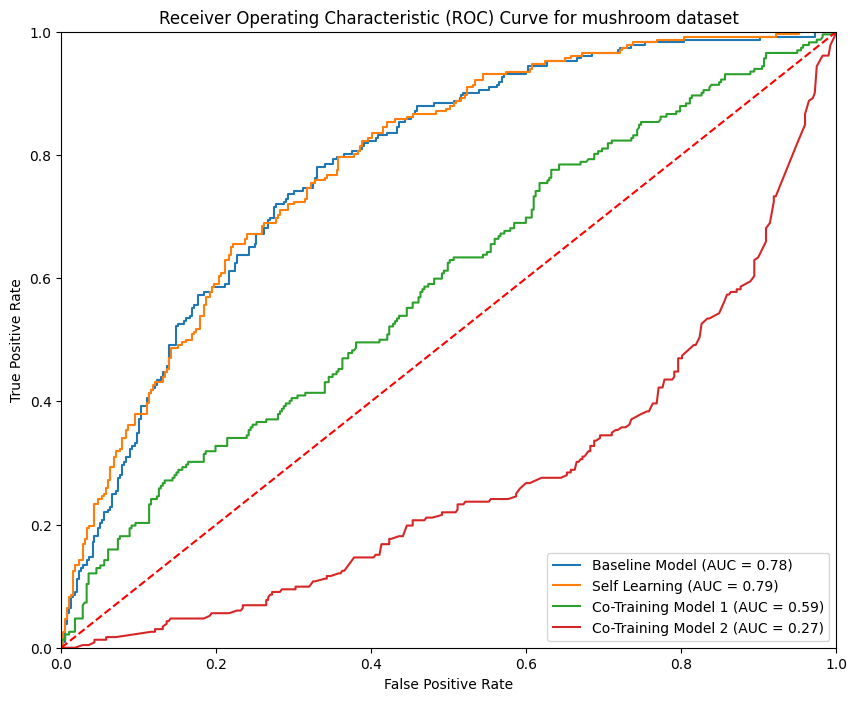

AUC of the baseline model:  0.7813015721358465
AUC of the self-training model:  0.7852970555024754
AUC of the 1st Co-Training Model: 0.5909026752366889
AUC of the 2nd Co-Training Model: 0.2735114653000955


In [27]:
features_subsets = joblib.load(os.path.join(
            constants.MODEL_DIR,
            constants.CO_TRAINING_BEST_FEATURE_SPLIT_RESULTS_FILENAME
        ));
AUC_baseline, AUC_selftraining, AUC_cotraining1, AUC_cotraining2 = plotROC(
    models={
        "Baseline Model": joblib.load(os.path.join(
            constants.MODEL_DIR,
            constants.MODEL_FILENAME
        )),
        "Self Learning": supervisedModel,
        "Co-Training Model 1": joblib.load(os.path.join(
            constants.MODEL_DIR,
            constants.MODEL_COTRAIN_1_FILENAME
        )),
        "Co-Training Model 2": joblib.load(os.path.join(
            constants.MODEL_DIR,
            constants.MODEL_COTRAIN_2_FILENAME
        ))
    },
    X_test=X_test,
    y_test=y_test,
    feature_subsets={
        "Co-Training Model 1": features_subsets["features_view1"],
        "Co-Training Model 2": features_subsets["features_view2"]
    },
    dataset="mushroom"
);
print("AUC of the baseline model: ", AUC_baseline);
print("AUC of the self-training model: ", AUC_selftraining);
print(f"AUC of the 1st Co-Training Model: {AUC_cotraining1}");
print(f"AUC of the 2nd Co-Training Model: {AUC_cotraining2}");